In [330]:
library("TSP")
concorde_path("~/concorde/TSP")

found: concorde concorde.c concorde.o 


In [316]:

library("hash")
library("sets")

dataTSP <- read_TSPLIB("/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/main.tsp")


pointSet <- hash()
noPts <- length(dataTSP)/2
for (i in 1:noPts){
    pointSet[[toString(i)]] <- tuple(dataTSP[i], dataTSP[i+noPts])
}

dist_pts <- function(pt1,pt2){
        return(sqrt((pt1[[1]]-pt2[[1]])^2 + (pt1[[2]]-pt2[[2]])^2))
}

angle <- function(x,y){
  dot.prod <- x%*%y 
  norm.x <- norm(x,type="2")
  norm.y <- norm(y,type="2")
  theta <- acos(dot.prod / (norm.x * norm.y))
  as.numeric(theta)
}

angle_pts <- function(pt1,pt2){
    
    if (pt1[[2]] -pt2[[2]] == 0){
        if (pt1[[1]] -pt2[[1]]>0){
            return(pi/2)
        }
        if (pt1[[1]] -pt2[[1]]<0){
            return(-pi/2)
        }
        if (pt1[[1]] -pt2[[1]]==0){
            return(0)
        }
    } else{
        x<- pt1[[1]] -pt2[[1]]
        y <-pt1[[2]] -pt2[[2]]
        angle <- atan((y)/(x))
        if (x < 0 & y>0){
            angle <- pi + angle
        }
        if (x >0 & y <0){
            angle <-2*pi +angle
        }
        if (x < 0 & y<0){
            angle <- pi + angle
        }
        return(angle)
        }
}


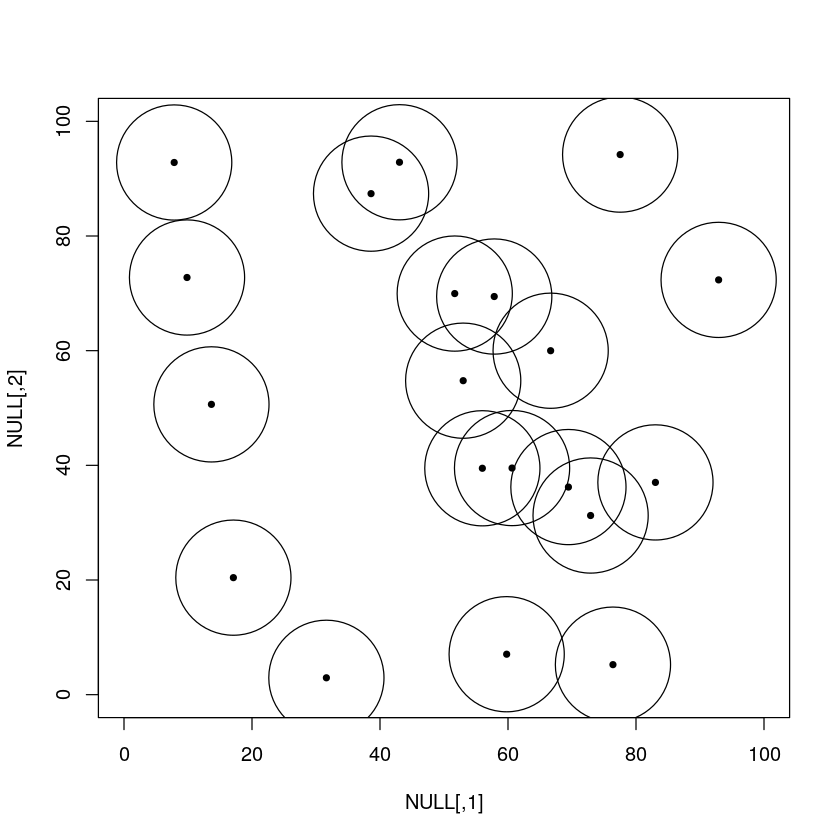

In [318]:
radius <-9
plot(dataTSP, xlim=c(0,100), ylim=c(0,100), pch=20)
symbols(dataTSP,circles=rep(radius,noPts), add=T, inches=F)


In [319]:
pivot_point <- values(pointSet, keys =1)

angle_based <- list()
distance_based <-list()

for (i in 1:noPts){
    compare_point <- values(pointSet, keys= i)
    element <-list(list(i, dist_pts(pivot_point,compare_point), angle_pts(compare_point,pivot_point)))
    angle_based <- append(angle_based, element)
    distance_based <- append(distance_based, element)
}




In [320]:
start_time <- Sys.time()

angle_based <- angle_based[order(sapply(distance_based, '[[', 3))]
end_time <- Sys.time()
end_time - start_time

Time difference of 0.002789497 secs

In [321]:
start_time <- Sys.time()

distance_based <- distance_based[order(sapply(distance_based,'[[',2))]
end_time <- Sys.time()
end_time - start_time

Time difference of 0.002803802 secs

In [322]:
get_item <- function(item_to_get, database){
    counter <-1
    cont <- TRUE 
    while (counter <= length(database) & cont == TRUE){
        data_pt <-database[[counter]]
        if (data_pt[1] == item_to_get){
            return(data_pt)
            cont <- FALSE
        }
        counter <- counter +1
    }
}

get_pts_range_dist <- function(lower_bound, higher_bound){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(distance_based) & cont ==TRUE){
        distance_wrt_pivot <- distance_based[[counter]]
        
        if (distance_wrt_pivot[[2]] >= lower_bound & distance_wrt_pivot[[2]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, distance_wrt_pivot[[1]])
        }
        if (distance_wrt_pivot[[2]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    return(eligible_vertices)
}

obtain_angle_range <- function(lower_bound, higher_bound){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(angle_based) & cont ==TRUE){
        angle_wrt_hor <- angle_based[[counter]]
        
        if (angle_wrt_hor[[3]] >= lower_bound & angle_wrt_hor[[3]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, angle_wrt_hor[[1]])
        }
        if (angle_wrt_hor[[3]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    print(eligible_vertices)
    return(eligible_vertices)
}

conform_angle <- function(angle){
    if (angle <0){
        angle <- 2*pi + angle
    }
    if (angle >2*pi){
        angle <- angle - 2*pi
    }
    
    return(angle)
}

get_pts_range_angle <- function(distance_from_pivot, radius, angle){
     eligible_vertices <-list()
    if (distance_from_pivot < 2*radius){
        print("point within 2*radius, angle sort doesn't provide another limit factor")
        for (point in 1:length(angle_based)){
            eligible_vertices <- append(eligible_vertices, angle_based[[point]][1])
            }
    }else{
        if (2*radius == distance_from_pivot){
            #r = d, gives the angle range that is 180 degrees. Gives which side?
            print("distance is 2*radius, will yield the 180 degree angle")
            higher_bound <- conform_angle(pi/2 - (pi - angle))
            lower_bound<- conform_angle(higher_bound + pi)
            print("the lower_bound is")
            print(lower_bound)
            print("the higher_bound is")
            print(higher_bound)
            eligible_vertices <- append(eligible_vertices, obtain_angle_range(lower_bound, higher_bound))
            print("elgible vertices in angle sort")
        }else{
            #r > d
            print("distance is larger than 2*radius")
            phi <- asin(2*radius/distance_from_pivot)
            if (angle + phi > 2*pi){
                diff <-  angle + phi -2*pi 
                eligible_vertices <- append(eligible_vertices, obtain_angle_range(0,diff))
                eligible_vertices <- append(eligible_vertices, obtain_angle_range(angle-phi, 2*pi))
                print("the lower_bound is")
                print(angle-phi)
                print("the higher_bound is")
                print(diff)
            } else {
                if (angle - phi < 0){
                    diff <- angle - phi 
                    eligible_vertices <- append(eligible_vertices, obtain_angle_range(2*pi + diff, 2*pi))
                    eligible_vertices <- append(eligible_vertices, obtain_angle_range(0, angle+phi))
                    print("the lower_bound is")
                    print(2*pi +diff)
                    print("the higher_bound is")
                    print(angle+phi)
                }else{
                    eligible_vertices <- append(eligible_vertices, obtain_angle_range(angle-phi, angle+phi))
                    print("the lower_bound is")
                    print(angle-phi)
                    print("the higher_bound is")
                    print(angle+phi)
                }
            }
        }
    }    
    return(eligible_vertices)

}

In [323]:
start_time <- Sys.time()
current_tree <- list()
checklist <-(c(1:noPts))
while (length(checklist) != 0){

    branch <- list()
    
    old_branch_len<- length(branch)

    startPt = checklist[1]
    branch<-append(branch, startPt)

    counter =1

    while(old_branch_len != length(branch)){

        current_branch_len <- length(branch)
        
        start <-old_branch_len+1
        pts_to_connect <- c(branch[start:current_branch_len])


        checklist <-checklist[!checklist %in% pts_to_connect]

        old_branch_len= current_branch_len

        for (connect_pt in pts_to_connect){
            ## to yield an estimates of near by points 
            pivot_data <- get_item(connect_pt, distance_based)
            dist_wrt_pivot <- pivot_data[[2]][1]
            angle_wrt_hor <-pivot_data[[3]][1]
            print("point to connect is")
            print(connect_pt)
            
            if (dist_wrt_pivot == 0){
                possible_connect <- get_pts_range_dist(0,2*radius)
                print("point to connect is the same as pivot. yielding proximity possible results only")
                print(possible_connect)
            } else {
                
                possible_angle <- get_pts_range_angle(dist_wrt_pivot, radius, angle_wrt_hor)
                print("possible vertices based on angle sorting")
                print(possible_angle)
                possible_dist <- get_pts_range_dist(dist_wrt_pivot-2*radius, dist_wrt_pivot+2*radius)
                print("possible vertices based on distance sorting")
                print(possible_dist)
                possible_connect <- intersect(possible_angle, possible_dist)
            }
            print("intersect list to compare")
            print(possible_connect)
            for (comparePt in possible_connect){

                if (!comparePt %in%branch){
                    vPt1 <-values(pointSet, keys=connect_pt) 
                    vPt2 <-values(pointSet, keys=comparePt) 
                    
                    if (dist_pts(vPt1,vPt2) <= 2*radius){
                        
                        branch<-append(branch,comparePt)
                        print("pt within range")
                        print(comparePt)
                        checklist <-checklist[!checklist %in% c(comparePt)]

                        
                    } else {}
                } else{}
            }
        }
        counter <- counter +1
        
    }
    current_tree <- append(current_tree, list(branch))
}
end_time <- Sys.time()
end_time - start_time


[1] "point to connect is"
[1] 1
[1] "point to connect is the same as pivot. yielding proximity possible results only"
[[1]]
[1] 1

[[2]]
[1] 19

[1] "intersect list to compare"
[[1]]
[1] 1

[[2]]
[1] 19

[1] "pt within range"
[1] 19
[1] "point to connect is"
[1] 19
[1] "point within 2*radius, angle sort doesn't provide another limit factor"
[1] "possible vertices based on angle sorting"
[[1]]
[1] 1

[[2]]
[1] 7

[[3]]
[1] 14

[[4]]
[1] 12

[[5]]
[1] 13

[[6]]
[1] 16

[[7]]
[1] 2

[[8]]
[1] 3

[[9]]
[1] 5

[[10]]
[1] 17

[[11]]
[1] 10

[[12]]
[1] 11

[[13]]
[1] 18

[[14]]
[1] 8

[[15]]
[1] 4

[[16]]
[1] 9

[[17]]
[1] 15

[[18]]
[1] 6

[[19]]
[1] 20

[[20]]
[1] 19

[1] "possible vertices based on distance sorting"
[[1]]
[1] 1

[[2]]
[1] 19

[[3]]
[1] 14

[[4]]
[1] 20

[[5]]
[1] 13

[[6]]
[1] 3

[[7]]
[1] 17

[1] "intersect list to compare"
[[1]]
[1] 1

[[2]]
[1] 14

[[3]]
[1] 13

[[4]]
[1] 3

[[5]]
[1] 17

[[6]]
[1] 20

[[7]]
[1] 19

[1] "point to connect is"
[1] 2
[1] "distance is large

Time difference of 0.1892378 secs

In [344]:
current_tree

[[1]]
[[1]][[1]]
[1] 1

[[1]][[2]]
[1] 19


[[2]]
[[2]][[1]]
[1] 2

[[2]][[2]]
[1] 5

[[2]][[3]]
[1] 10

[[2]][[4]]
[1] 11

[[2]][[5]]
[1] 3

[[2]][[6]]
[1] 17

[[2]][[7]]
[1] 14

[[2]][[8]]
[1] 13

[[2]][[9]]
[1] 7


[[3]]
[[3]][[1]]
[1] 4


[[4]]
[[4]][[1]]
[1] 6


[[5]]
[[5]][[1]]
[1] 8

[[5]][[2]]
[1] 18


[[6]]
[[6]][[1]]
[1] 9


[[7]]
[[7]][[1]]
[1] 12


[[8]]
[[8]][[1]]
[1] 15


[[9]]
[[9]][[1]]
[1] 16


[[10]]
[[10]][[1]]
[1] 20

In [361]:
output<-system("~/concorde/TSP/concorde")
output

[1] 1

In [346]:
do.call(rbind.data.frame, current_tree)

ERROR: Error in xi[[j]]: subscript out of bounds


1       
[1,] 59.79141
[2,] 7.056561

[1] 27.51698

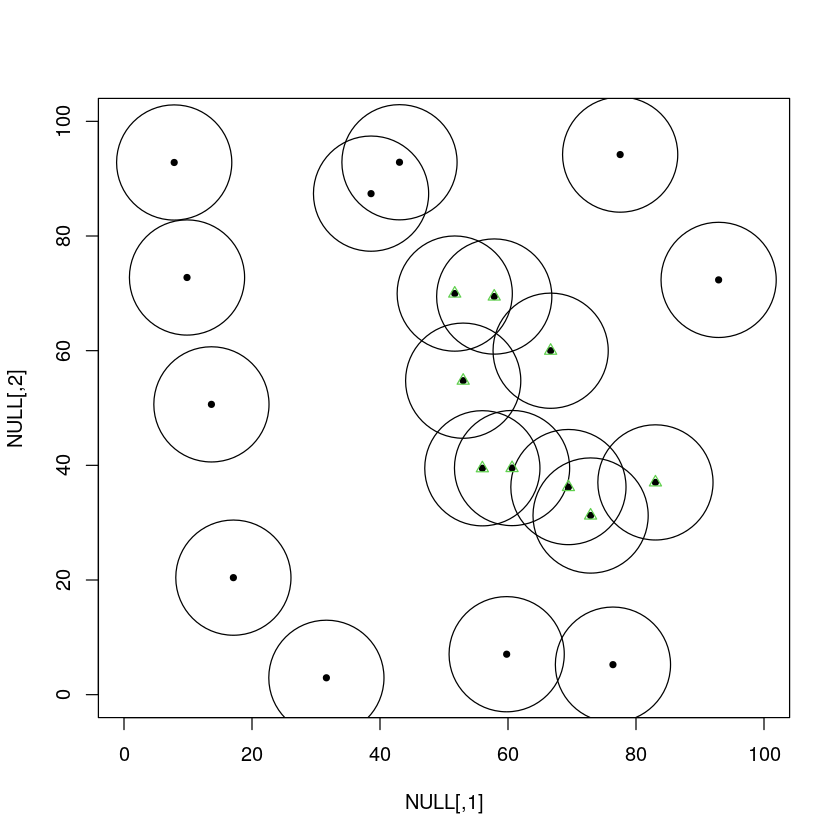

In [325]:
plot(dataTSP,xlim=c(0,100), ylim=c(0,100), pch=20)
symbols(dataTSP, circles=rep(radius,noPts), add=T, inches=F)
branchNo = 2
for (all in current_tree[[branchNo]]){
    pt <- values(pointSet, keys =all)
    points(pt[[1]],pt[[2]], col="3", pch=2)
}

manual_pt <- values(pointSet, keys =1)
#points(manual_pt[[1]],manual_pt[[2]], col="2", pch=5)
check <- c(9, 14)
for (pt in check){
    #manual_pt <- values(pointSet, keys =pt)
    #points(manual_pt[[1]],manual_pt[[2]], col="4", pch=3)
}

vPt1 <-values(pointSet, keys=1) 
vPt2 <-values(pointSet, keys=14) 
vPt3 <-values(pointSet, keys =12)
#dist_pts(vPt1,vPt2)

vPt1
#vPt2
#vPt3
#angle_pts(vPt2,vPt1)
#dist_pts(vPt2,vPt1)
#angle_pts(vPt3,vPt1)
dist_pts(vPt2,vPt1)
#dist_pts(vPt2,vPt3)

In [273]:
x <- toString(length(current_tree))
cap <- nchar(x, type = "chars")


for (branchNo in 1:length(current_tree)){
    if (cap >1){
        branchNum <- toString(branchNo)
        times <- cap - nchar(branchNum, type="chars" )
        for (t in 1:times){
            branchNum <- paste0("0", toString(branchNum))
        } else {
            
        }
    }
    pts  <- data.frame(x=c(), y=c())
    if ( length(current_tree[[branchNo]]) <=2){
        ##write solution to be the same as the output to .sol file
        file_name <- sprintf("/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/branch_%s_case_%s.sol",branchNum,1)
        if (length(branch) == 1){
            write(c(1,0), file_name)
        }

        if (length(branch) == 2){
            write(c(2, 1, 0), file_name)
        }

    }else{

        for (pt in current_tree[[branchNo]]){
            pt_data <- values(pointSet, keys=pt) 
            pts <- rbind(pts, c(pt_data[[2]],pt_data[3]))

        }
        etsp <- ETSP(pts)
            file_name <- sprintf("branch_%s_case_%s.tsp",branchNum,1)
            write_TSPLIB(etsp, file= file_name)
    }
}

ERROR: Error in rbind(deparse.level, ...): invalid list argument: all variables should have the same length


In [ ]:
write(c(2,1,0), "/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/test.sol" )

In [ ]:
x <- scan("/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/solution_files.txt", what=character())
for (i in x){
    print(i)
}

In [ ]:
for (i in x){
    print(i)
}

ls | grep 'branch\_[0-9]*\_case\_[0-9]*\.tsp'
use this command to select case based in order to run concorde with

Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


[1] 400.2047

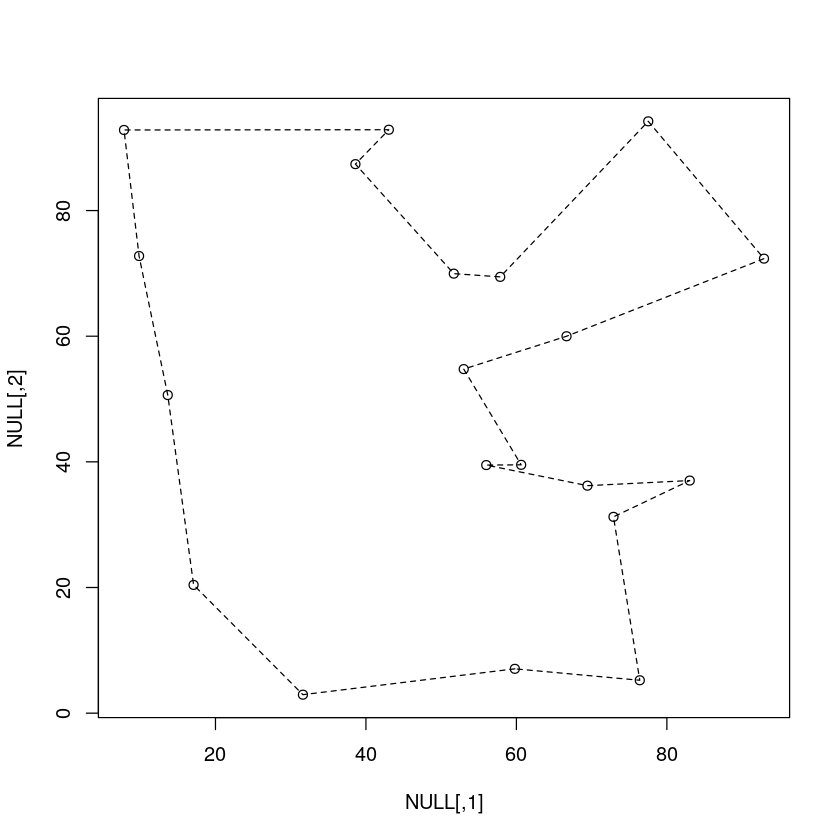

In [342]:
tour_concorde <- solve_TSP(dataTSP,method="concorde")
plot(dataTSP, tour_concorde)
tour_length(tour_concorde)

In [333]:
tsp <- dist(dataTSP, method="euclidean")
tsp

            1          2          3          4          5          6          7
2   53.379791                                                                  
3   32.481211  21.335310                                                       
4  100.272978  67.362126  75.015238                                            
5   62.417945  12.924035  30.046627  55.200910                                 
6   44.739986  63.435030  47.552692  73.000905  63.760524                      
7   37.924963  28.208093  22.543486  93.636518  41.055883  68.005372           
8   83.080136  39.216776  52.688870  31.236039  26.313888  70.347854  67.164981
9   82.535104  58.234580  60.695859  20.159536  48.117217  52.851910  81.451187
10  63.424597  17.997752  31.723315  49.438720   6.192746  60.425839  45.478101
11  48.189894  14.629523  17.043552  59.054974  15.459320  49.694750  34.886349
12  73.209212  29.009572  46.032203  87.497168  35.181699  91.900977  36.677439
13  30.709378  23.943249   9.411582  83.

In [307]:
x <- toString(length(current_tree))
nchar(x, type = "chars")




[1] 1

In [308]:
branchNo <- 1
branchNum <- toString(branchNo)
times <- 3
for (t in 1:times){
            branchNum <- paste0("0", toString(branchNum))
        }
branchNum

[1] "0001"

In [313]:
no <- readline(prompt="input: ")

input: 2


In [315]:
as.integer(no)

[1] 2

In [367]:
tsp <- as.TSP(dataTSP)

Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


[1] 383.6321

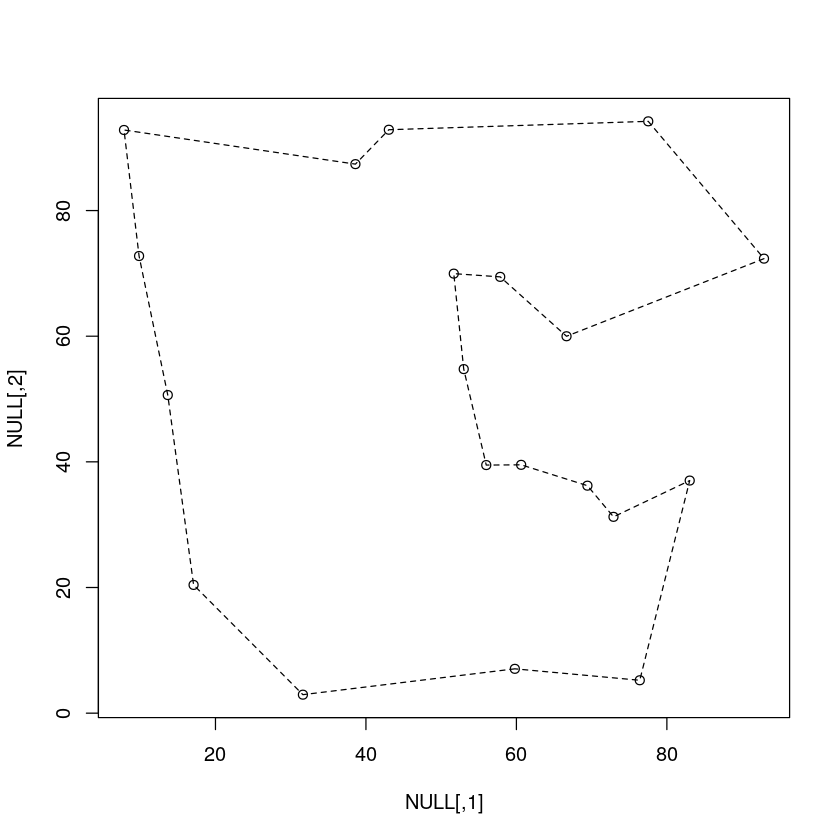

In [373]:
tour <- solve_TSP(tsp, method="concorde")
plot(dataTSP, tour)
tour_length(tour)

In [374]:
tour

object of class ‘TOUR’ 
result of method ‘concorde’ for 20 cities
tour length: 383.6321

In [375]:
convert_sol_format <- function(content){
    content <- content[-1]
    for (index in 1:length(content)){
        content[[index]] <- content[[index]] + 1
    }
    return(as.TOUR(as.integer(content)))
}

In [380]:
content<- scan("main.sol")
Rtour <- convert_sol_format(content)
Rtour

object of class ‘TOUR’ 
result of method  for 20 cities
tour length: unknown

[1] NA

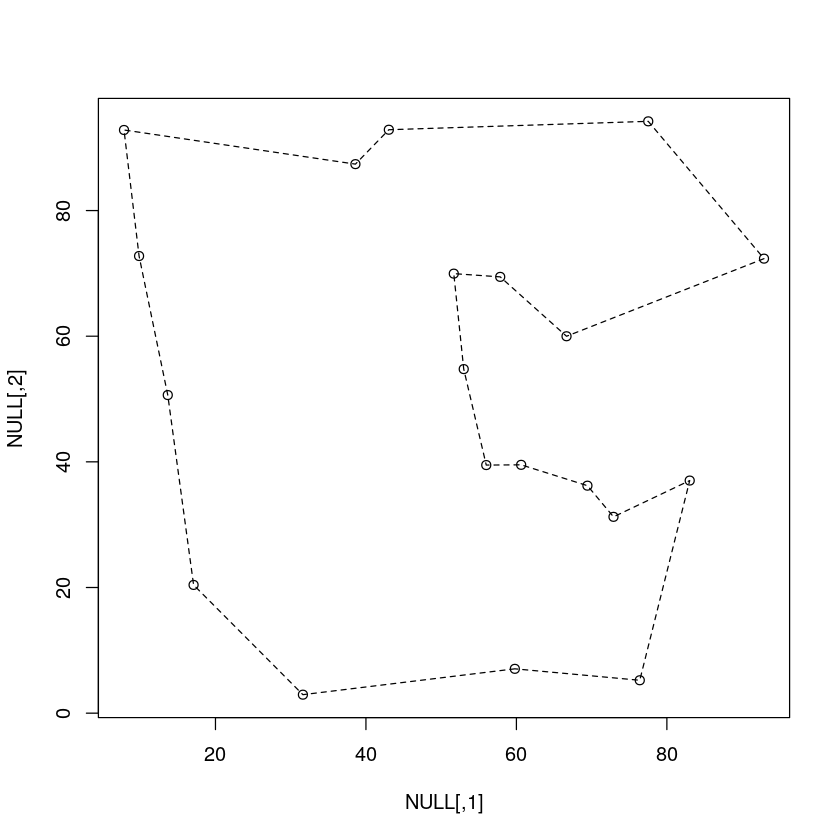

In [379]:
plot(dataTSP, Rtour)
tour_length(Rtour)